# 타이타닉 튜토리얼
우리는 이 튜토리얼에서 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것입니다.

In [1]:
#기본 설정
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# seaborn : 시각화 라이브러리,맷플롯립보다는 떨어지지만 훨씬 간편하고 시각적으로 예쁘다
plt.style.use('seaborn')
sns.set(font_scale=2.5)
import missingno as msno
# missingno : 시각화 라이브러리를 통해 결측치를 확인하고 처리하도록 도와준다 
import warnings
# warnings : 경고창을 숨기거나 다시 나타낼수 있게 할 수 있다 , 다시 나타내게 할땐 'default'
warnings.filterwarnings('ignore')
%matplotlib inline
#그래프가 원래 새로운창에서 출력이되는데 노트북에서 보길원하기때문에 inline을 넣어줌


앞으로 거쳐야할 프로세스는 다음과 같습니다.
1. 데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.
2.탐색적 데이터 분석(Exploratory Data Analysis) - 여러 feature들을 개별적으로 분석하고, feature들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insightfmf 얻습니다.
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature들을 engineering합니다. one-hotencoding,class로 나누기, 구간으로 나누기, 텍스트 데이터 처리등을 합니다.
4.model 만들기 - sklearn을 사용해 모델을 만듭니다. 파이썬에서 머신러닝을 할 때는 sklearn을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow,pytorch 등을 사용할 수 도 있습니다.
5. 모델 학습 및 예측 - trainset을 가지고 모델을 학습시킨 후, testset을 가지고 prediction합니다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는지 확인해봅니다.

# 1. Dataset 확인
- 파이썬에서 테이블화 된 데이터를 다루는데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 pandas입니다.
- 우리는 pandas를 사용하여 데이터셋의 간단한 통계적 분석부터, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있습니다.
- 파이썬으로 데이터분석을 한다고하면 반드시 능숙해져야 할 라이브러리이니, 여러 커널들을 공부하시면서 사용법에 익숙해지도록 반복 또 반복하시길 권장합니다.
- 캐글에서 데이터셋은 보통 train, testset으로 나뉘어 있습니다.

In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 우리가 다루는 문제에서 feature는 Pclass(티켓의 클래스),age(나이),Sibsp(형제와 배우자의수),parch(부모및 아이의수),Fare(탑승료)이며, 예측하려는 target label 은 survived(생존여부)입니다.
- pandas dataframe에는 describe()메소드가 있는 데, 이를 쓰면 각 feature이 가진 통계치들을 반환해줍니다.

In [3]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


- 테이블에서 보다시피, PassenserID숫자와 다른,그러니까 null data가 존재하는 열(feature)이 있는 것 같습니다.
- 이를 좀 더 보기 편하도록 그래프로 시각화해서 살펴봅시다.

# 1.1 Null data check

In [5]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)
# >는 오른쪽 정렬을 의미하고 뒤에 숫자를 넣으면,해당 자릴수만큼 문자가 지정되고 남은 공간은 공백으로 채워집니다.
# 0.nf는 n자리까지 소수점이 출력됨을 의미한다


column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [6]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


- train, Test set 에서 Age(둘다 약 20%),Cabin(약80%),Embarked(train만 0.22%) null data 존재하는 것을 볼 수 있습니다.
- MANO라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있습니다.


<AxesSubplot:>

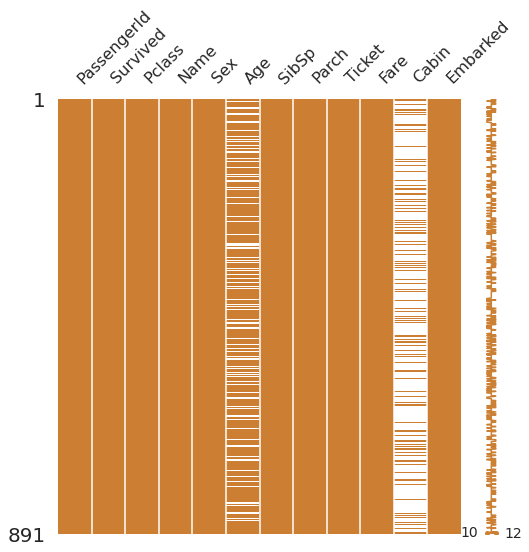

In [7]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8,8), color=(0.8, 0.5, 0.2))
# color파라미터는 RGB를 지정해준다
# figsize는 도형의 크기지정
# df.iloc[3:] : 4번째 행부터 출력

<AxesSubplot:>

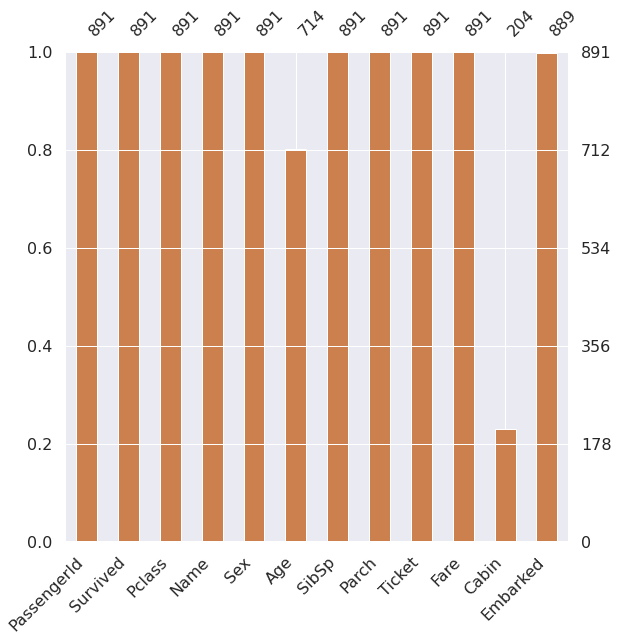

In [8]:
msno.bar(df=df_train.iloc[:, :], figsize=(9,9), color=(0.8, 0.5, 0.3))

<AxesSubplot:>

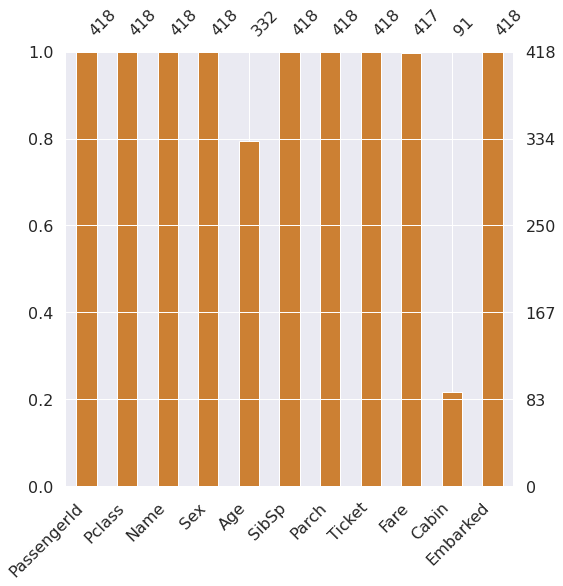

In [9]:
msno.bar(df=df_test.iloc[:, :], figsize=(8,8), color=(0.8, 0.5, 0.2))

# 1.2 Target label 확인
- target label이 어떤 distribution을 가지고 있는지 확인해봐야 합니다.
- 지금같은 binary classification 문제의 경우에서, 1과0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있습니다.



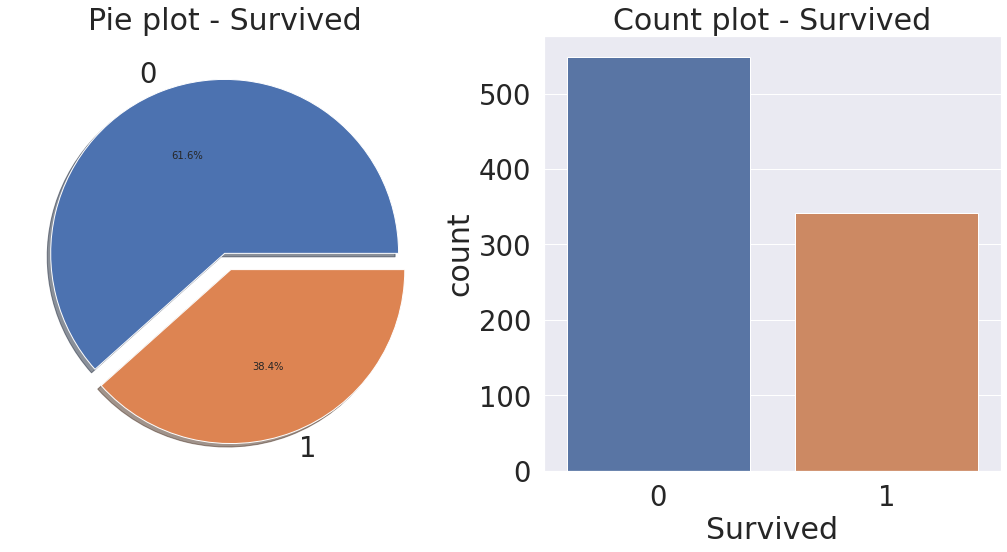

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18,8))  # subplots(행의수,열의수), ax : 그림을 그릴수 있는공간 
df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)  
# .pie : 원형 그래프 # ax[0] : 첫번째 공간에 그림  # autopct : %.nf는 소수n번째까지 출력, %%는 %를 출력 # explode : 각 파이가 떨어진정도
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')
plt.show()

- 안타깝게도 죽은 사람이 많습니다.
- 38.4%가 살아남았습니다.
- target label의 분포가 제법 균일합니다. 불균일한 경우, 예를 들어서 100명중 1이 99, 0이 1개인 경우에는 만약 모델이 모든것을 1이라 해도 정확도가 99%가 나오게 됩니다. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 됩니다. 지금 문제에서는 그렇지 않으니 계속 진행하겠습니다.

# 2.Exploratory data analysis(EDA)
- 이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.
- 시각화 라이브러리는 matplotlib,seaborn,plotly 등이 있습니다. 특정목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.

# 2.1 Pclass
- 먼저 Pclass에 대해서 살펴보겠습니다. Pclass는 ordinal,서수형 데이터입니다. 카테고리이면서,순서가 있는 데이터 타입입니다.
- 먼저 Pclass에 따른 생존률의 차이를 살펴보겠습니다. 엑셀의 피벗차트와 유사한 작업을 하게되는데,pandas dataframe에서는 groupby를 사용하면 쉽게 할 수 있습니다. 또한 pivot이라는 메소드도 있습니다.
- 'Pclass','Survived'를 가져온 후, pclass로 묶습니다. 그러고 나면 각 pclass마다 0,1이 count가 되는데, 이를 평균내면 각 pclass 별 생존률이 나옵니다.
- 아래와 같이 count()를하면 ,각class에 몇명이 있는지 확인할 수 있으며, sum()을 하면, 216명중 생존한(survived=1)사람의 총합을 주게 됩니다.

In [11]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()
# as_index : 이 그룹을 인덱스로 지정할것인지 아닌지를 묻는 명령어임

,Survived
Pclass,
1,216
2,184
3,491


In [12]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


- panda의 crosstab을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [13]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')
# margins=True : 표의 끝에 총계를 넣고싶을때 사용
# style.background_gradient(cmap='summer_r'): cmap은 colormap의 약자이고, 색상을 정의한다.

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


- grouped객체에 mean()을 하게 되면, 각 클래스별 생존률을 얻을 수 있습니다. class1이면 아래와 같습니다.

136/(80 + 136) ≈ 0.63

<AxesSubplot:xlabel='Pclass'>

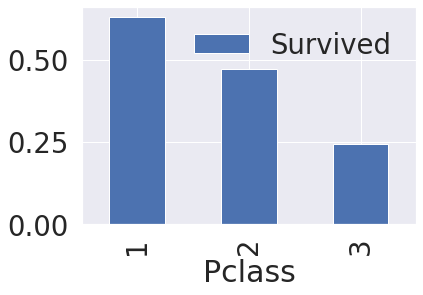

In [14]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()
# sort_values() : index기준으로 정렬,기본적으로 오름차순
# sort_values(ascending=False) : 내림차순
# by에 기준이되는 행설정

- 보다시피, Pclass가 좋을수록 생존률이 높은 것을 확인할 수 있습니다.
- 좀 더 보기 쉽게 그래프를 그려보겠습니다. seaborn의 countplot을 이용하면, 특정label에 따른개수를 확인해볼 수 있습니다. 

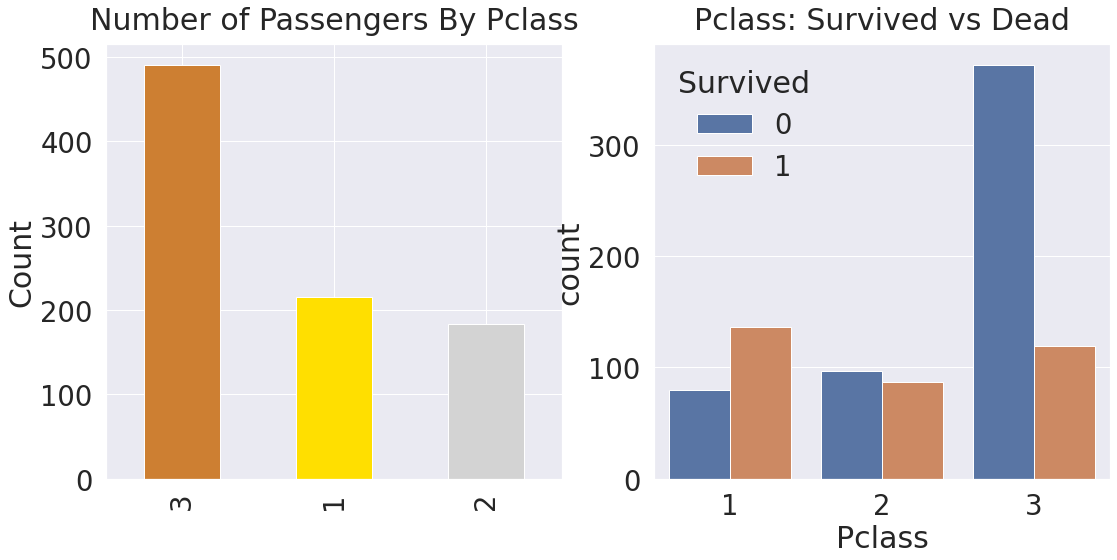

In [15]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()
# sns.countplot() : 카테고리별 개수를 세어준다
# x='Pclass' : 세로로 표시   # hue : 세부카테고리설정
# y_position : 도형과 제목사이의 간격설정

- 클래스가 높을 수록, 생존 확률이 높은걸 확인할 수 있습니다. Pclass 1,2,3순서대로 63%,48%,25% 입니다.
- 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feature를 사용하는 것이 좋을 것이라 판단할 수 있습니다.

# 2.2 Sex
- 이번에는 성별로 생존률이 어떻게 달라지는지 확인해보겠습니다.
- 마찬가지로 pandas groupby와 seaborn countplot을 사용해서 시각화해봅시다.

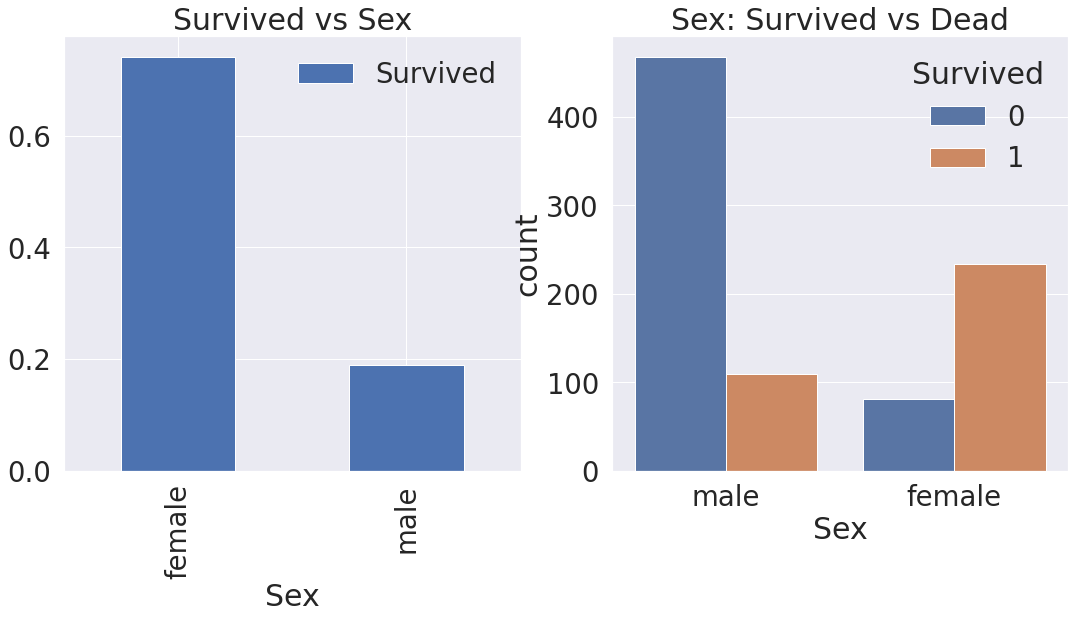

In [16]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

- 보시다시피, 여자가 생존할 확률이 높습니다.

In [17]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [18]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있습니다.

# 2.3 Both Sex and Pclass
- 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는 지 확인해 봅시다.
- seaborn의 factorplot을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다.

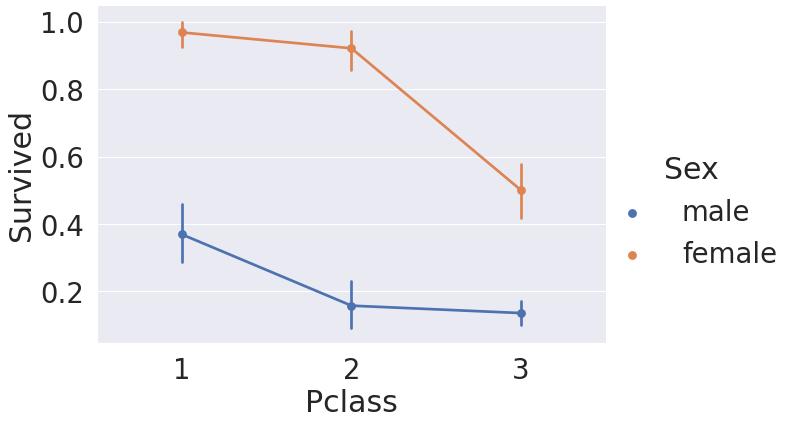

In [19]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)

- 모든 클래스에서 female이 살 확률이 male보다 높은 걸 알 수 있습니다.
- 또한 남자, 여자 상관없이 클래스가 높을 수록 살 확률 높습니다.
- 위 그래프는 hue 대신 column으로 하면 아래와 같아집니다.

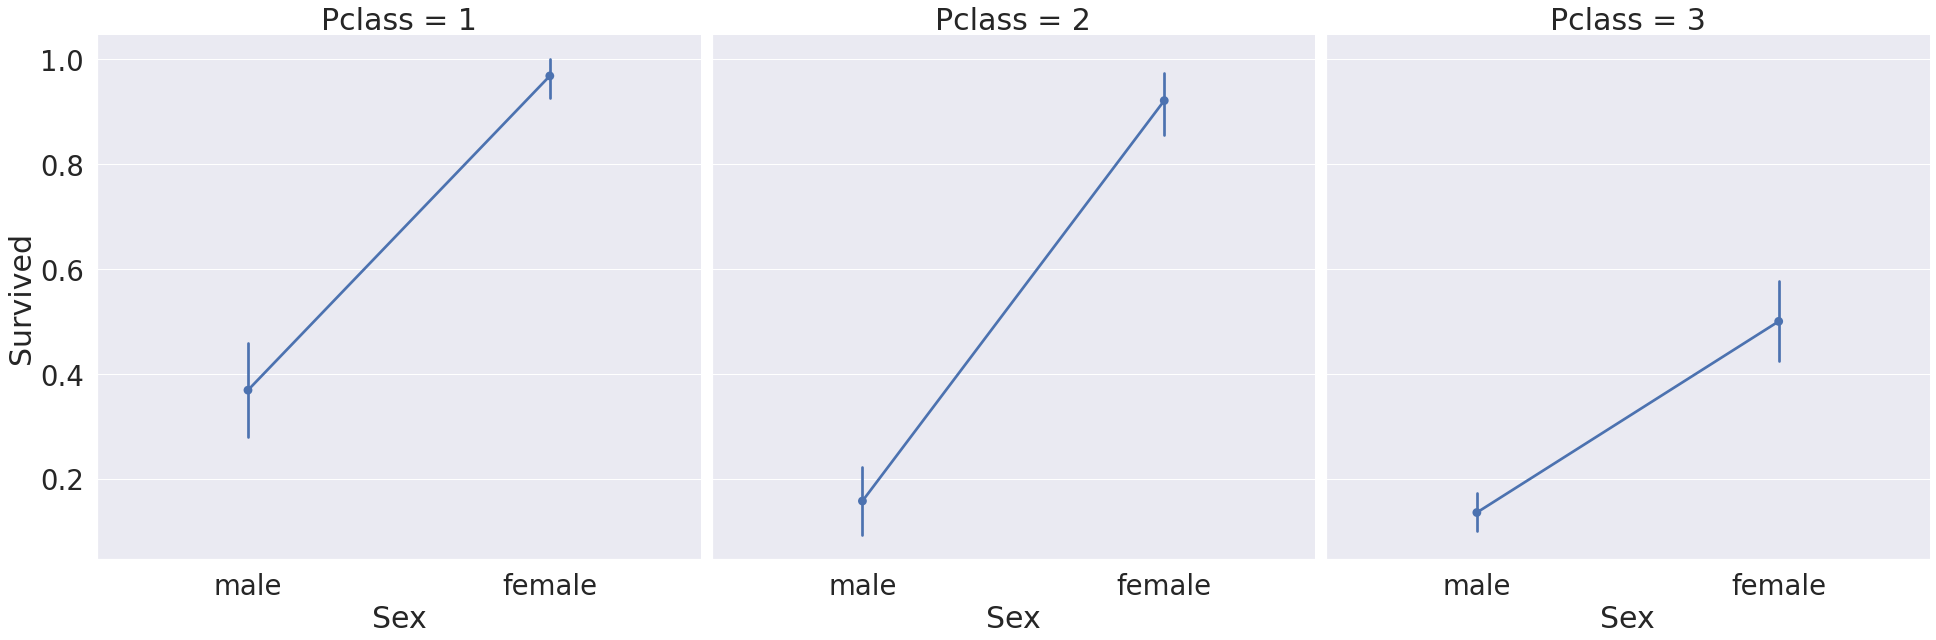

In [20]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, saturation=.5, size=9, aspect=1)
# hue : 한곳에 중첩   col : 개수별로 분리

# 2.4 Age
- 이번에는 Age feature를 살펴봅시다.

In [21]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


- 생존에 따른 Age의 histogram을 그려보겠습니다.

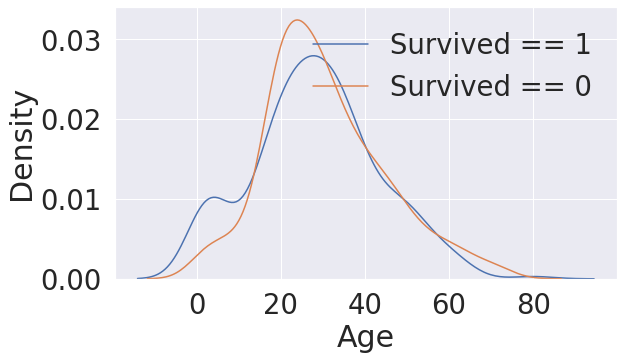

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()
# kdeplot : 밀도플롯

- 보시다시피, 생존자 중 나이가 어린경우가 많음을 볼 수 있습니다.

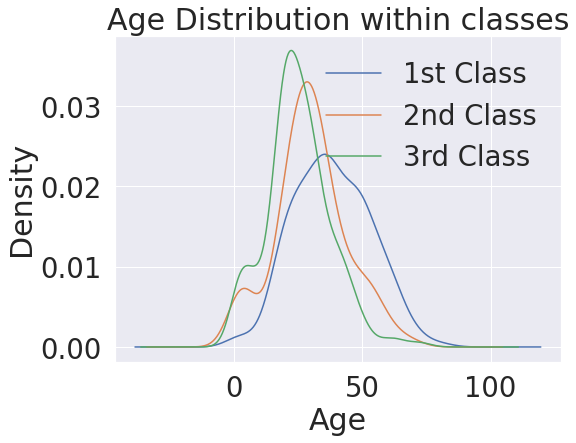

In [23]:
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')
plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

- Class가 높을 수록 나이많은 사람의 비중이 커짐
- 나이대가 변하면서 생존률이 어떻게 되는지 보려고 합니다.
- 나이범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다.

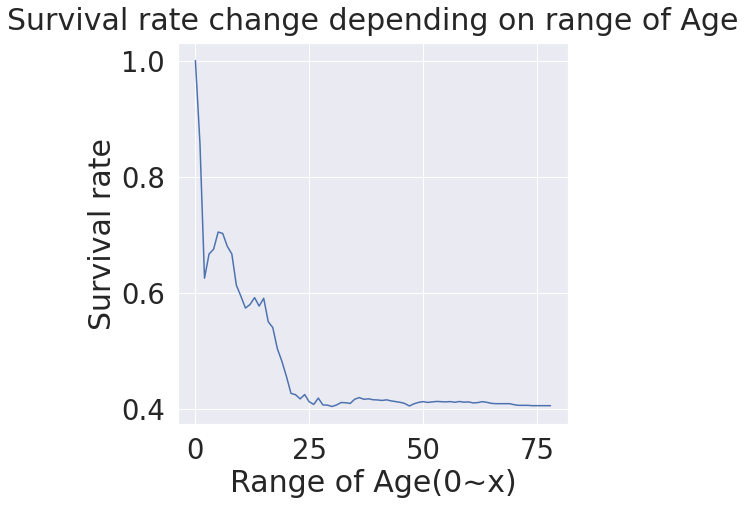

In [24]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

- 보시다시피, 나이가 어릴수록 생존률이 확실히 높은것을 확인할 수 있습니다.
- 우리는 이 나이가 중요한 feature로 쓰일 수 있음을 확인했습니다.

# 2.5 Pclass, Sex, Age
- 지금까지 본, Sex, Pclass, Age, Survived 모두에 대해서 보고싶습니다. 이를 쉽게 그려주는 것이 seaborn의 violinplot입니다.
- x축은 우리가 나눠서 보고싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(Age)입니다.
- 한번 그려보겠습니다.

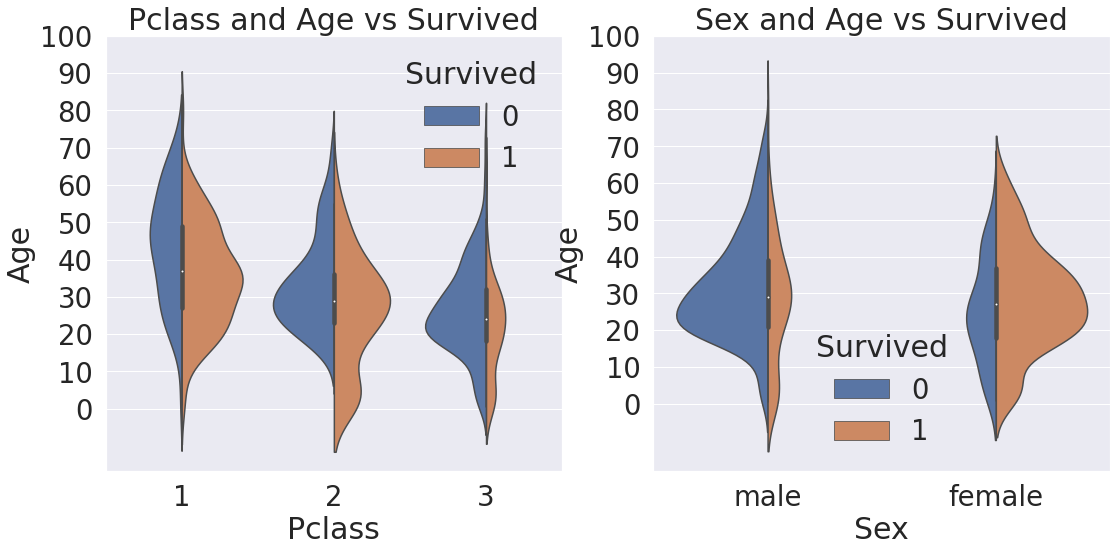

In [25]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()
# violinplot : 바이올린플롯, 숫자형데이터를 표시

- 왼쪽 그림은 Pclass 별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프입니다.
- 오른쪽 그림도 마찬가지로 Sex, 생존에 따른 distribution이 어떻게 다른지 보여주는 그래프입니다.
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한것을 볼 수 있습니다.
- 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한것을 볼 수 있습니다.
- 여성과 아이를 먼저 챙긴 것을 볼 수 있습니다.

# 2.6 Embarked
- Embarked는 탑승한 항구를 나타냅니다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠습니다.

<AxesSubplot:xlabel='Embarked'>

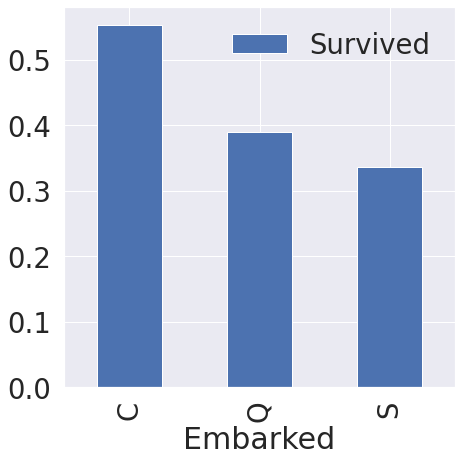

In [26]:
f, ax = plt.subplots(1, 1, figsize=(7,7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax)

- 보시다시피, 조금의 차이는 있지만 생존률은 좀 비슷한거 같습니다. 그래도 C가 제일 높군요.
- 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠습니다.
- 사실, 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한역학을 했는지 확인해볼 수 있습니다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것입니다.
- 다른 feature로 split하여 한번 살펴보겠습니다.

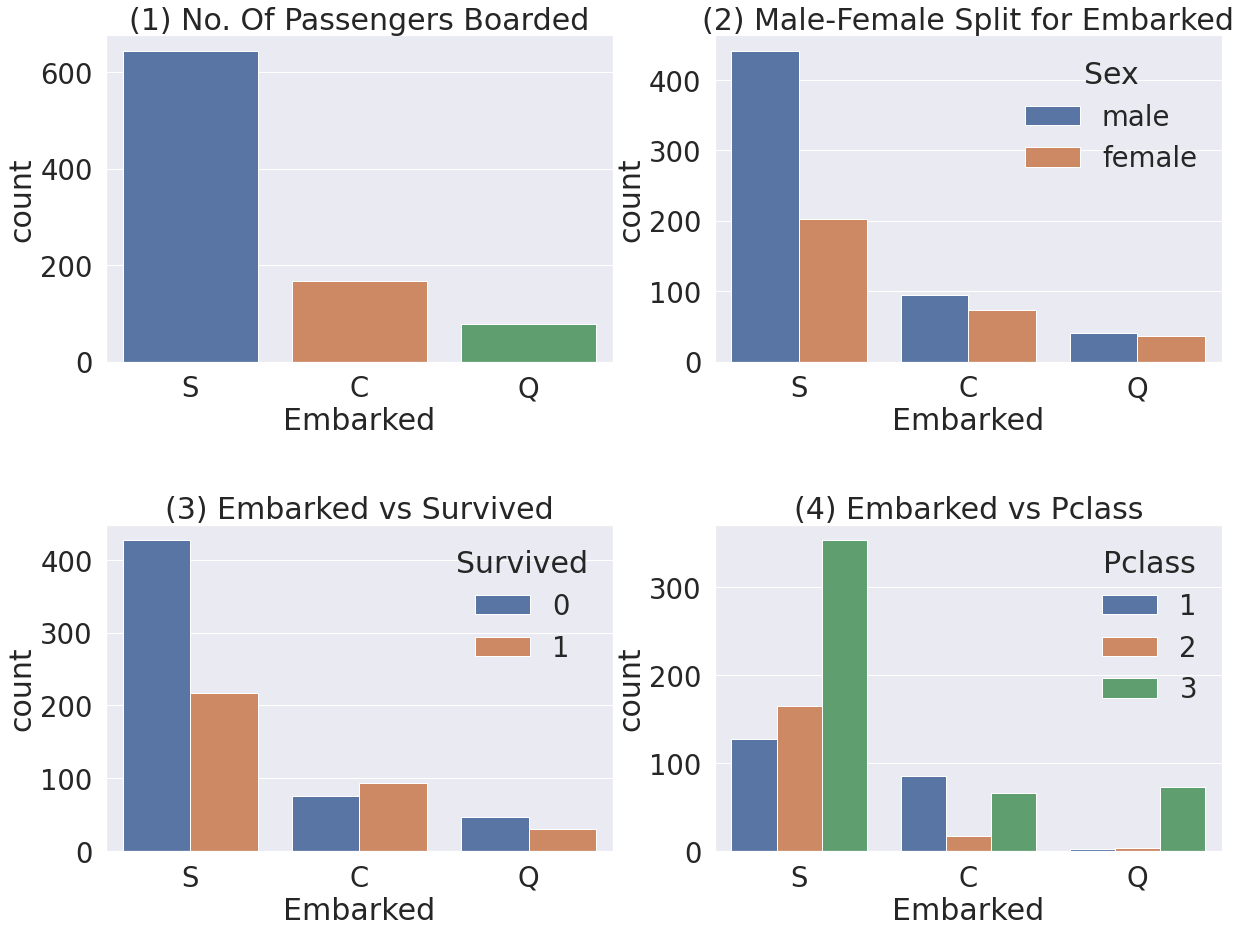

In [27]:
f, ax=plt.subplots(2, 2, figsize=(20,15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
# wspace : 중간 세로간격  hspace : 중간 가로간격

- Figure(1) - 전체적으로 봤을 때, S에서 가장 많은 사람이 탑승했습니다.
- Figure(2) - C와Q는 남녀의 비율이 비슷하고, S는 남자가 더 많습니다.
- Figure(3) - 생존확률이 S경우 많이 낮은 걸 볼 수 있습니다.
- Figure(4) - Class로 split해서 보니, C가 생존확률이 높은건 클래스가 높은 사람이 많이 타서 그렇습니다. S는 3rd class가 많아서 생존확률이 낮게 나옵니다. 

# 2.7 Family - SibSp(형제 자매) + Parch(부모,자녀)
- SibSp와 Parch를 합하면 Family가 될것입니다. Family로 합쳐서 분석해봅시다.

In [28]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 #자신포함
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


- FamilySize와 생존의 관계를 한번 살펴봅시다.

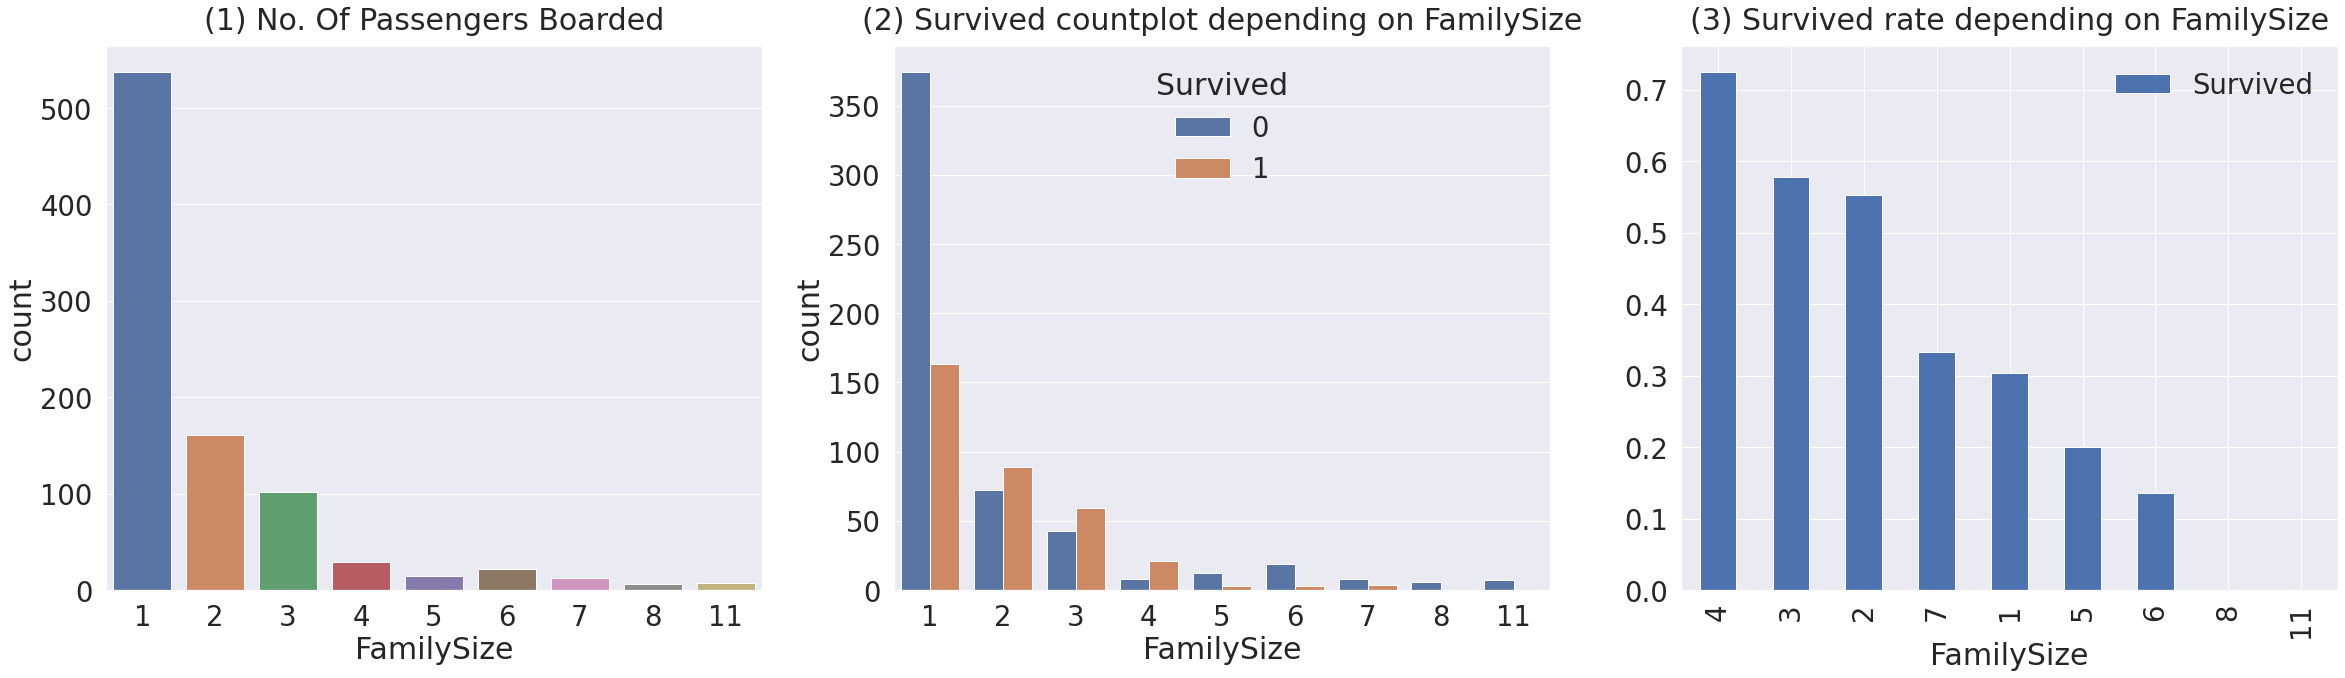

In [29]:
f, ax=plt.subplots(1, 3, figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)
sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure (1) - 가족의크기가 1~11까지 있음을 볼 수 있습니다. 대부분 1명이고, 그 다음으로 2, 3, 4명입니다.
- Figure (2), (3) - 가족 크기에 따른 생존비교입니다. 가족이 4명인 경우가 가장 생존확률이 높습니다. 가족수가 많아질수록, (5, 6, 7, 8, 11) 생존확률이 낮아지네요. 가족수가 너무작아도(1), 너무 커도(5, 6, 8, 11) 생존확률이 높은 걸 확인할 수 있습니다.

# 2.8 Fare
- Fare는 탑승요금이며, contious feature입니다. 한번 histogram을 그려보겠습니다.

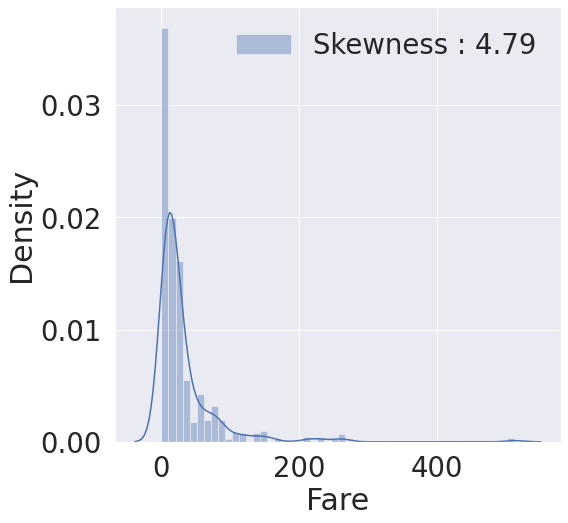

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'],color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g = g.legend(loc='best')
# distplot을 사용하여 히스토그램을 만들수있고,히스토그램은 수치형 데이터분포를 표현해주는 그래프이다.
# skewness(왜도) : 분포의 비대칭정도, 왼쪽으로 치우칠수록 +값이 나온다. 정규분포는 0
# legend의 위치를 대략적으로 설정하고자한다면 키워드입력변수인 loc를 사용하면된다. 여기서 'best'를 입력할경우 자동으로 최적의 위치계산

- 보시다시피, distribution이 매우 비대칭인것을 알 수 있습니다.(high skewness). 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못학습할 수도 있습니다. 몇개 없는 outlier에 대해서 너무 민감하게반응한다면, 실제 예측시에 좋지 못한 결과를 부를 수 있습니다.
- outlier의 영향을 줄이기 위해 Fare에 log를 취하겠습니다.
- 여기서 우리는 pandas의 유용한 기능을 사용할 겁니다. dataFrame의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply를 사용하면 매우 손쉽게 적용할 수 있습니다.
- 우리가 지금 원하는 것은 Fare columns의 데이터 모두를 log값 취하는 것인데, 파이썬의 간단한 lambda함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns데이터에 그대로 적용이 됩니다. 매우 유용한 기능이니 꼭 숙지하세요!

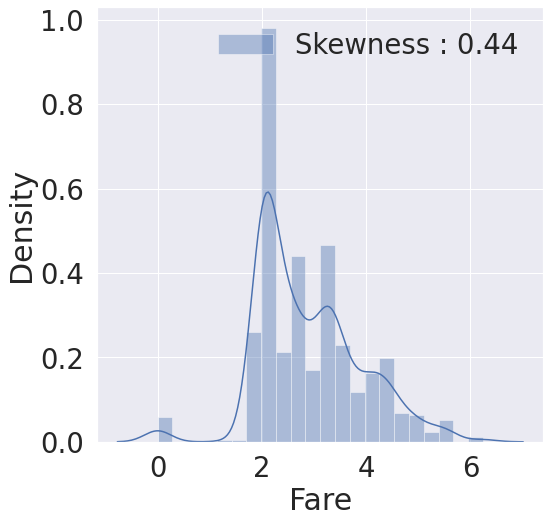

In [31]:
df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'],color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g = g.legend(loc='best')
# df.loc[행 인덱싱 값, 열 인덱싱 값] : 해당 행과열에있는 값을 가져온다.

- log를취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
- 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
- 사실 방금한 것은 feature engineering에 들어가는 부분인데, 여기서 작업했습니다.
- 모델을 학습시키기위해, 그리고 그 모델의 성능을 높이기 위해 feature들에 여러 조작을 가하거나, 새로운 feature를 추가하는것은 feature engineering이라고하는데, 우리는 이제 그것을 살펴볼 것입니다.

# Cabin
- 이 feature는 NaN이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않습니다.
- 그러므로 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다.

In [32]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


# 2.10 Ticket
- 이 feature는 NaN은 없습니다. 일단 string data이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요합니다.

In [33]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

- 보시다시피,ticket number는 매우 다양합니다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까요?
- 여러분이 직접 한번 아이디어를 내보세요! 이것이 본격적인 캐글 레이스의 시작점입니다.
- 이 튜토리얼에서는 튜토리얼이니 일단 ticket은 넘기도록 하겠습니다.튜토리얼을 끝낸후, 여러분의 모델의 성능을 향상시키기 위해 ticket에서 정보를 이끌어내는것도 좋겠네요!